In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import datetime

import svg_render_helpers as rdh
from scipy.spatial import distance

### file hierarchy and database connection vars

In [11]:
## directory & file hierarchy
# iterationName = 'cdm_run_v4'
# exp_path = 'museumstation'
iterationName = 'CDM_photodraw_e1'
exp_path = 'photodraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))

tracing_dir = os.path.join(analysis_dir,'photodraw_tracing2')
if not os.path.exists(tracing_dir):
    os.makedirs(tracing_dir)

## dir where we can keep all sketches not binned by category    

In [12]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db[iterationName]

### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [13]:
total_sessions = coll.find().distinct('sessionId') ## this returns ALL sessions in this collection.
print 'We currently have {} total sessions.'.format(len(total_sessions))

We currently have 89 total sessions.


In [14]:
## see  https://docs.google.com/spreadsheets/d/1pZ2MFfAjoT_11ZJQcSAjdeA_ZZvRraTZRqkVBcVIXCM/edit#gid=8551646
## for information on which 
exclude_session_id=['CDM_photodraw_e11532109648493',
'CDM_photodraw_e11532110198274',
'CDM_photodraw_e11532119534231',
'CDM_photodraw_e11532120540660',
'CDM_photodraw_e11532121593015',
'CDM_photodraw_e11532123507785',
'CDM_photodraw_e11532454335609',
'CDM_photodraw_e11532455751579',
'CDM_photodraw_e11532455837908',
'CDM_photodraw_e11532463418268',
'CDM_photodraw_e11532468803382',
'CDM_photodraw_e11532472054977',
'CDM_photodraw_e11532540831557',
'CDM_photodraw_e11532543365329',
'CDM_photodraw_e11532551867786',
'CDM_photodraw_e11532556255130',
'CDM_photodraw_e11532558764161',
'CDM_photodraw_e11533073503103',
'CDM_photodraw_e11533144107489',
'CDM_photodraw_e11533147048549',
'CDM_photodraw_e11532463825380',
'CDM_photodraw_e11532461805013',
'CDM_photodraw_e11532541701592']

In [ ]:
# basic descriptors
session_id = []; trial_num = []; category = []; age = []; filename = []

# stroke times and duration
svg = []; svg_times = []; draw_duration_old = []; draw_duration_new = []

# drawing usage stats
num_strokes = []
mean_intensity = []
bounding_box = []

# trial time and duration
start_time = []; submit_time = []; trial_duration = []

# other timing variables
submit_date = []
submit_date_readable = []

def load_image_data(imgData,imsize):
    filestr = base64.b64decode(imgData)
    fname = os.path.join('sketch.png')
    with open(fname, "wb") as fh:
        fh.write(imgData.decode('base64'))
    im = Image.open(fname).resize((imsize,imsize))
    _im = np.array(im)
    return(_im)

def get_mean_intensity(img,imsize):
    thresh = 250
    numpix = imsize**2
    mean_intensity = len(np.where(img[:,:,3].flatten()>thresh)[0])/numpix
    return mean_intensity
    
def get_bounding_box(img):
    bounding_box = None
    try:
        rows = np.any(img, axis=1)
        cols = np.any(img, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        bounding_box = tuple((rmin, rmax, cmin, cmax))
    except Exception as e:
        print 'Oops, something went wrong! Here is the error:'  
        print e
        pass
                
    return bounding_box

fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532111112405_age7/this square.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532111112405_age7/this shape.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532111112405_age7/this circle.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532113637303_age4/this shape.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532113637303_age4/this circle.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532114278628_age5/this square.png
fpath /Us

fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532547528521_age4/this square.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532547528521_age4/this circle.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532552096322_age4/this square.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532552096322_age4/this shape.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532552096322_age4/this circle.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11532552431212_age6/this square.png
fpath /U

fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11533145279933_age5/this square.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11533145279933_age5/this shape.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11533145279933_age5/this circle.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11533145985106_age4/this square.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11533145985106_age4/this shape.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11533146317748_age7/this square.png
fpath /Us

Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11533162144527_age5/this circle.png
fpath /Users/zixianchai/Desktop/compositionality/shapedraw/analysis/tracing/photodraw_tracing2/CDM_photodraw_e11533164692587_age4/this square.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'


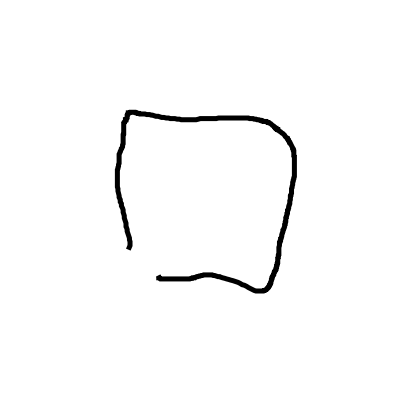

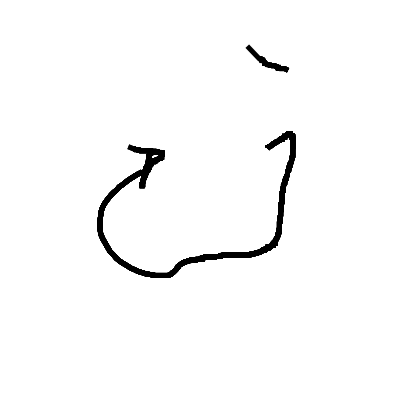

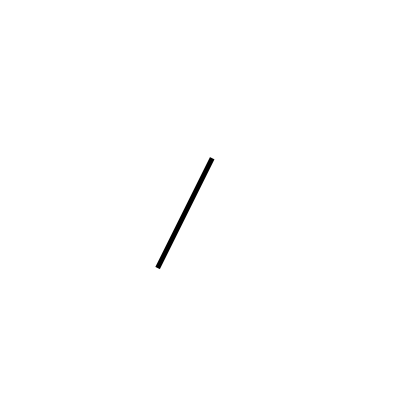

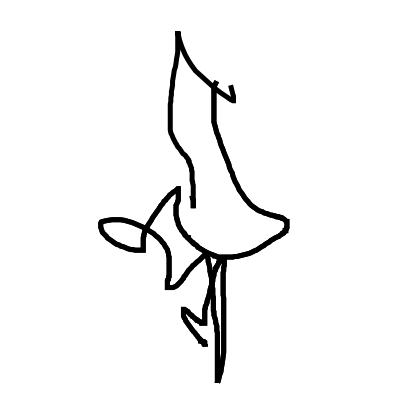

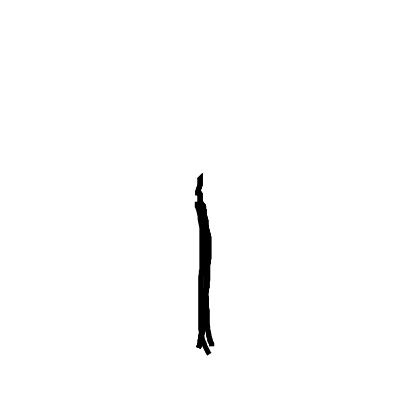

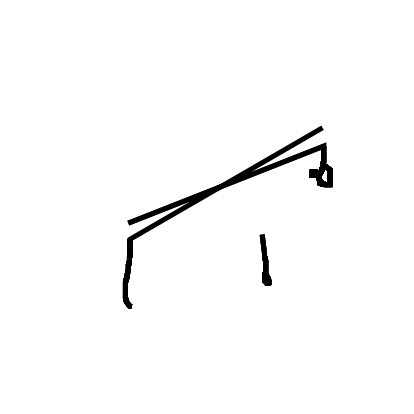

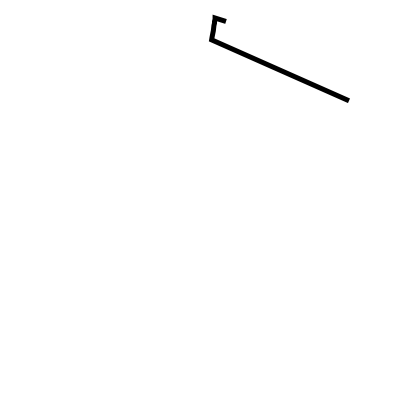

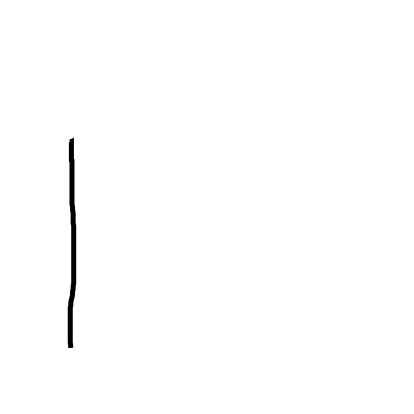

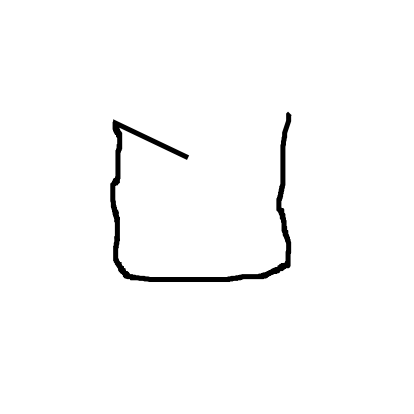

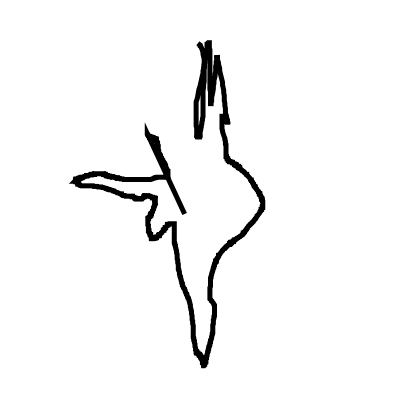

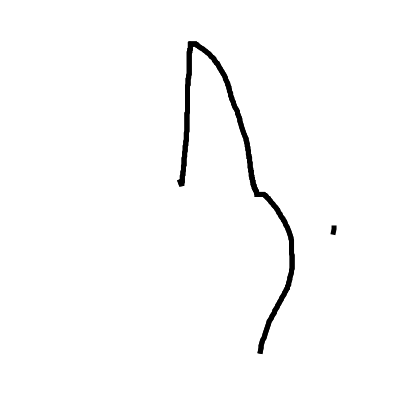

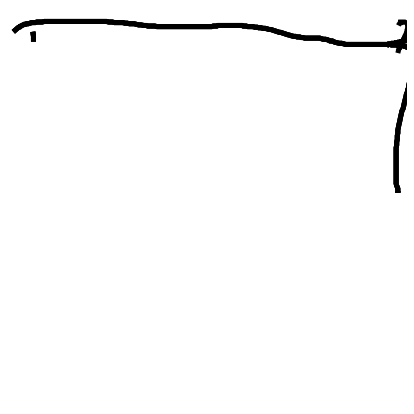

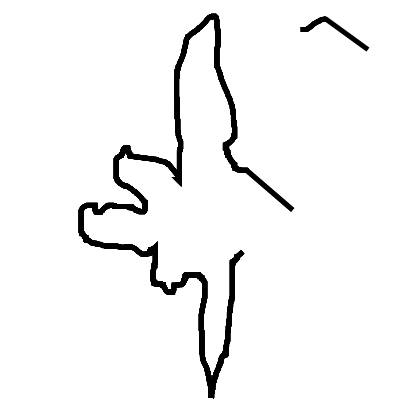

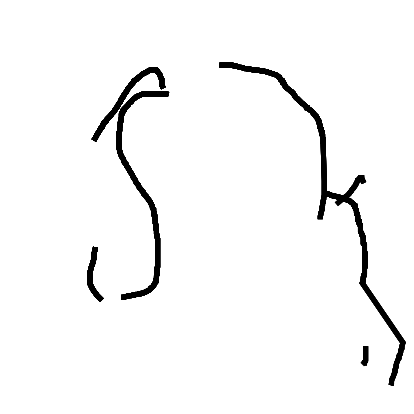

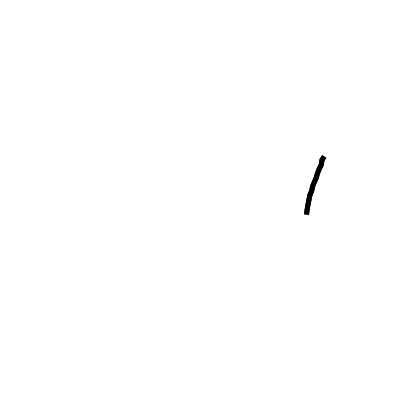

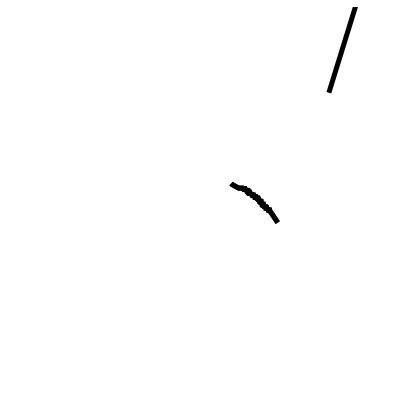

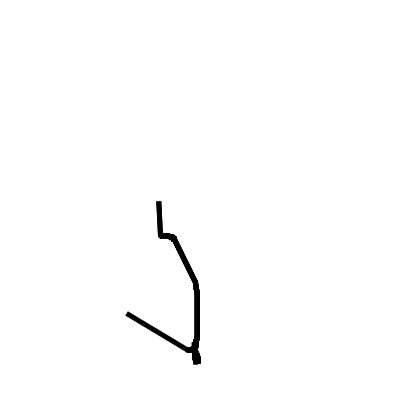

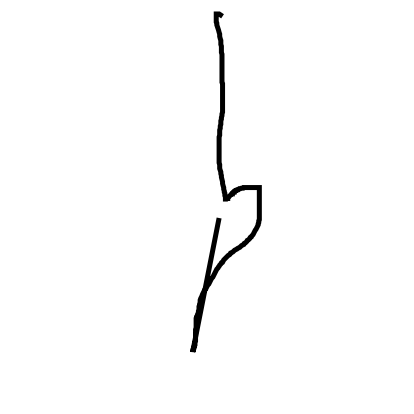

In [15]:
tracing = ['this circle','this square','this shape']
exclude_age = ['age8','age9','age10']
canvas_size = 696
imsize = 400
# tracing = ['square', 'shape', 'this circle']
# canvas_size = 809
image_recs = coll.find({'$and': [{'dataType':'finalImage'}]})


for imrec in image_recs:      
    if imrec['sessionId'] not in exclude_session_id and imrec['category'] in tracing and imrec['age'] not in exclude_age:
#     if imrec['category'] in tracing:
        stroke_recs = coll.find({'$and': [{'sessionId':imrec['sessionId']}, 
                                {'dataType':'stroke'},
                                {'category': imrec['category']}]}).sort('time')  
        try:
        ## check to make sure that there is at least one stroke! 
            if stroke_recs.count()>0 and stroke_recs.count()<50:

                ## some handy metadata for writing out the sketch PNG filename
                category = imrec['category']
                session_id = imrec['sessionId']
                age = imrec['age']

                ## now make an svg list!
                svg_list = rdh.make_svg_list(stroke_recs)

                ## now get me some verts and codes!
                Verts, Codes = rdh.get_verts_and_codes(svg_list)
                outpath = os.path.join(tracing_dir,'{}_{}'.format(session_id, age))

                ## now render out your cumulative sketches and save out as pngs!
                rdh.render_and_save(Verts,
                                Codes,
                                outpath,
                                line_width=5,
                                imsize=400,
                                canvas_size=canvas_size,
                                category=category)
                
        except Exception as e:
            print 'Oops, something went wrong! Here is the error:'  
            print e
            pass

